# Import modules

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import qiskit
import pylatexenc
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import gym
from functools import reduce
from collections import deque, defaultdict

In [4]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
import math, random, time, itertools
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter, ParameterVector
from tqdm.notebook import tqdm
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, CircuitOp, AerPauliExpectation
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.utils import QuantumInstance, algorithm_globals

In [5]:
from Curling import Curling
from ansatz import build_circuit

# Build CIrucit

### Ansatz list
- 'base'
- 'hw_eff'
- 'universal'
- 'universal_encoding'

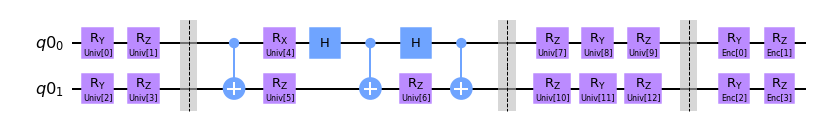

In [6]:
def draw_example():
    quantum_circuit, param_rot, param_enc = build_circuit(n_qubits=2, n_layers=1, opt='universal_encoding')
    return quantum_circuit
draw_example().draw('mpl')

In [7]:
# circuit, rot_params, enc_params = build_circuit(n_qubits=2, n_layers=1)

In [8]:
class PQC_with_DataReuploading(nn.Module):
    def __init__(self, n_qubits, n_layers, output_dim, observables=None, ansatz='base', activation='linear'):
        super().__init__()
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.output_dim = output_dim
        self.activation = activation
        self.ansatz = ansatz
        
        if observables == None:
            self.observables = Z^n_qubits
        else:
            self.observables = observables
        
        # Build circuits / Parameter Vectors
        self.circuit, self.rot_params, self.enc_params = build_circuit(self.n_qubits, self.n_layers, ansatz)
        self.len_rot_params = len(self.rot_params)
        self.len_enc_params = len(self.enc_params)
        
        self.psi = CircuitStateFn(primitive=self.circuit, coeff=1.)
        self.Op = ~StateFn(self.observables) @ self.psi
        
        # set method to calculcate expected values
        expval = AerPauliExpectation()
        # define gradient method
        gradient = Gradient()
        # define quantum instances (statevector and sample based)
        qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
        # we set shots to 10 as this will determine the number of samples later on.
        qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1000)
        
        self.qnn = OpflowQNN(operator=self.Op, input_params=self.enc_params, weight_params=self.rot_params, 
                             exp_val=expval, gradient=gradient, quantum_instance=qi_sv, input_gradients=True)
        
        self.total_params = []
        for p in self.rot_params:
            self.total_params.append(p)
        for p in self.enc_params:
            self.total_params.append(p)
        
        # Initial Parameters for circuit
#         self.rot_param_vals = nn.Parameter(2*np.pi * torch.rand(len(self.rot_params)))
        self.rot_param_vals = nn.Parameter(2*np.pi * torch.rand(len(self.rot_params)))
#         self.enc_param_vals = nn.Parameter(torch.ones(len(self.enc_params)))
#         self.enc_param_vals  = nn.Parameter(nn.Parameter(torch.rand(len(self.enc_params))))
        self.enc_param_vals  = nn.Parameter(torch.rand(len(self.enc_params)))
        
        # Parameter for circuit output
#         self.w = nn.Parameter(nn.Parameter(torch.rand(self.output_dim)))
        self.w = nn.Parameter(torch.tensor([-1,1], dtype=torch.float32))
        
    def forward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
    
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        
        action_exp = torch.tensor(expectation) * self.w
        action_prob = F.softmax(action_exp, dim=1)
        
        return action_prob

    def backward(self, inputs):
        input_tiled = self.get_input_tiled(inputs)
        input_scaled = self.enc_param_vals * input_tiled
        input_params = input_scaled
        expectation = self.qnn.forward(input_params.detach(), self.rot_param_vals.detach())
        enc_grad, rot_grad = self.qnn.backward(input_params.detach(), self.rot_param_vals.detach())
        w_grad = torch.tensor(expectation).tile(self.output_dim)
        return torch.tensor(rot_grad.squeeze()), torch.tensor(enc_grad.squeeze()), w_grad
    
    def get_input_tiled(self, inputs):
        # Input: State values -> Need to insert into Encoding gates with scaling parameters(encoding params)
        if self.ansatz == 'universal_encoding' or self.ansatz == 'hw_eff':
            input_tiled = inputs.tile(2)
            input_tiled = input_tiled.tile(self.n_layers)
        elif self.ansatz == 'universal':
            input_tiled = torch.zeros((inputs.shape[0], inputs.shape[1]+1))
            input_tiled[:,:2] = inputs
            input_tiled[:,-1] = inputs[:,-1]
        else:
            input_tiled = inputs.tile(self.n_layers)
        return input_tiled

In [9]:
policy = PQC_with_DataReuploading(n_qubits=2, n_layers=1, output_dim=2, ansatz='universal_encoding')

In [10]:
policy.observables

PauliOp(Pauli('ZZ'), coeff=1.0)

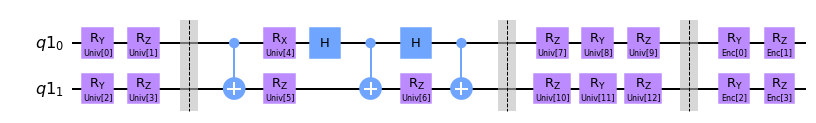

In [11]:
policy.circuit.draw('mpl')

In [12]:
inputs = torch.rand((10,2))

In [13]:
policy.rot_param_vals

Parameter containing:
tensor([4.2040, 5.8307, 2.0783, 1.6211, 5.4307, 1.8429, 5.2639, 3.8446, 1.8152,
        1.7525, 3.3046, 2.4152, 4.8974], requires_grad=True)

In [14]:
policy.enc_param_vals

Parameter containing:
tensor([0.6335, 0.7819, 0.0929, 0.1285], requires_grad=True)

In [15]:
policy.w

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [16]:
policy.forward(inputs)

tensor([[0.4559, 0.5441],
        [0.4493, 0.5507],
        [0.4533, 0.5467],
        [0.4477, 0.5523],
        [0.4496, 0.5504],
        [0.4497, 0.5503],
        [0.4488, 0.5512],
        [0.4552, 0.5448],
        [0.4545, 0.5455],
        [0.4482, 0.5518]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

In [17]:
s = time.time()
a,b,c = policy.backward(inputs)
print(time.time()-s)

0.9611060619354248


# Make Quantum Agent

In [27]:
class QuantumAgent():
    def __init__(self, input_state_dim, n_actions, n_layers=1, ansatz='base'):
        self.policy = PQC_with_DataReuploading(n_qubits=input_state_dim, n_layers=n_layers, 
                                               output_dim=n_actions, observables=None, ansatz=ansatz,
                                               activation='linear')
        self.n_layers = n_layers
#         self.variational_optim = torch.optim.Adam([self.policy.rot_param_vals], lr=0.1)
#         self.encoding_optim = torch.optim.Adam([self.policy.enc_param_vals], lr=0.1)
#         self.weight_optim = torch.optim.Adam([self.policy.w], lr=0.01)
        
        self.lr = 0.1
        
#         self.optims = [self.variational_optim, self.encoding_optim, self.weight_optim]
        
    def get_actions(self, input_state):
        return self.policy.forward(input_state)
    
    def update_policy(self, states, id_action_pairs, returns, action_probs, batch_size):
        r_grad, e_grad, w_grad = self.policy.backward(states)
        
        p_actions = torch.tensor([action_probs[id_action_pairs[i][0], id_action_pairs[i][1]] for i in range(action_probs.shape[0])])
        p_actions = p_actions.reshape(p_actions.shape[0], -1)
        action_idxs = id_action_pairs[:,1]
        
        returns = returns.reshape(returns.shape[0], -1)
        action_weights = agent.policy.w.detach().numpy()[id_action_pairs[:,1]]
        action_weights = action_weights[:,np.newaxis]
        action_weights = torch.tensor(action_weights)
        
        w = agent.policy.w.tile(len(states)).reshape(len(states),-1)
        
        sum_action_weight = torch.sum((action_probs * w), dim=1)
        
        rot_grad = np.array([(returns[i] * ( action_weights[i] * r_grad[i] - sum_action_weight[i] * r_grad[i] )).detach().numpy() 
                    for i in range(len(returns))])
        
#         input_scaled = self.policy.enc_param_vals * self.policy.get_input_tiled(states)
        input_scaled = self.policy.get_input_tiled(states)
        enc_grad = returns * ( input_scaled * action_weights * e_grad 
                              - sum_action_weight.reshape((sum_action_weight.shape[0],-1)) * input_scaled * e_grad)
        
#         weight_grad = returns * ( w_grad * action_weights - torch.mean(p_actions * w) * w_grad)
        
        prev = self.policy.rot_param_vals.detach().numpy().copy()
        prev1 = self.policy.enc_param_vals.detach().numpy().copy()
#         prev2 = self.policy.w.detach().numpy().copy()
        
#         rot_update = (torch.mean(rot_grad.detach(), dim=0) / batch_size).type(torch.float32)
#         enc_update = (torch.mean(enc_grad, dim=0).detach() / batch_size).type(torch.float32)
#         w_update = (torch.mean(weight_grad, dim=0).detach() / batch_size).type(torch.float32)

        rot_update = torch.sum(torch.from_numpy(rot_grad), dim=0) / batch_size
        enc_update = torch.sum(enc_grad, dim=0) / batch_size
#         w_update = torch.mean(weight_grad, dim=0) / batch_size
        
        with torch.no_grad():            
            self.policy.rot_param_vals += self.lr*rot_update
            self.policy.enc_param_vals += self.lr*enc_update
#             self.policy.w += 5 * w_update

#         self.policy.rot_param_vals.grad = -1*rot_update
#         self.policy.enc_param_vals.grad = -1*enc_update
#         self.policy.w.grad = -1*w_update
                
#         print(rot_update)
#         print(enc_update)
        
#         self.variational_optim.step()
#         self.encoding_optim.step()
#         self.weight_optim.step()

        print('rot updated')
        print(self.policy.rot_param_vals.detach() - prev)
#         print(rot_update)
        print('enc updated')
        print(self.policy.enc_param_vals.detach() - prev1)
#         print(enc_update)
#         print(self.policy.w.detach() - prev2)
#         print(w_update)
        
#         print('w', self.policy.w)
        
#         with torch.no_grad():
#             self.policy.rot_param_vals[self.policy.rot_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.enc_param_vals[self.policy.enc_param_vals > 2*np.pi] = 2*np.pi
#             self.policy.rot_param_vals[self.policy.rot_param_vals < 0] = 0
#             self.policy.enc_param_vals[self.policy.enc_param_vals < 0] = 0
        

In [28]:
n_qubits = 2 # Dimension of Input
n_layers = 1
n_actions = 2 # Dimention of output
agent = QuantumAgent(input_state_dim = n_qubits, n_actions=n_actions, n_layers=n_layers, ansatz='universal_encoding')

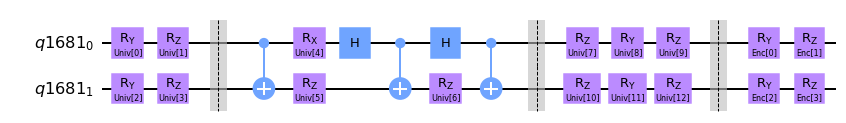

In [29]:
agent.policy.circuit.draw('mpl')

# Run Episodes and Update Policy

In [30]:
def gather_episodes(state_bounds, n_actions, agent, n_episodes, env_name):
    """Interact with environment in batched fashion."""

    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    if env_name == 'Curling':
        envs = [Curling("each_end_counts") for _ in range(n_episodes)]
#         envs = [Curling("winner_takes_it_all") for _ in range(n_episodes)]
    else:
        envs = [gym.make(env_name) for _ in range(n_episodes)]

    done = [False for _ in range(n_episodes)]
    states = [e.reset() for e in envs]

    while not all(done):
        unfinished_ids = [i for i in range(n_episodes) if not done[i]]
        normalized_states = [s/state_bounds for i, s in enumerate(states) if not done[i]]

        for i, state in zip(unfinished_ids, normalized_states):
            trajectories[i]['states'].append(state)

        states = torch.from_numpy(np.array(normalized_states))
        action_probs = agent.get_actions(states)

        # Store action and transition all environments to the next state
        states = [None for i in range(n_episodes)]
        for i, action_prob in zip(unfinished_ids, action_probs.detach().numpy()):
            action = np.random.choice(n_actions, p=action_prob)
            states[i], reward, done[i], _ = envs[i].step(action)
            trajectories[i]['actions'].append(action)
            trajectories[i]['rewards'].append(reward)
            trajectories[i]['action probs'].append(action_prob)

    return trajectories

def compute_returns(rewards_history, gamma):
    """Compute discounted returns with discount factor `gamma`."""
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [31]:
# env_name = "CartPole-v1"
env_name = "Curling"
if env_name == "CartPole-v1":
    state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
elif env_name == 'Curling':
    state_bounds = np.array([2*np.pi/60, 1])
gamma = 1
batch_size = 5
n_episodes = 500

In [32]:
# Start training the agent
episode_reward_history = []
# Monitoring reward
monitor_reward_history = []
for batch in tqdm(range(n_episodes // batch_size)):
    # Gather episodes
    episodes = gather_episodes(state_bounds, n_actions, agent, batch_size, env_name)

    # Group states, actions and returns in numpy arrays
    states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
    actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
    action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
    rewards = [ep['rewards'] for ep in episodes]
    returns = np.concatenate([compute_returns(ep_rwds, gamma) for ep_rwds in rewards])
    returns = torch.from_numpy(np.array(returns))

    id_action_pairs = torch.from_numpy(np.array([[i, a] for i, a in enumerate(actions)]))

#     print(states)
    print(action_probs)
    
    # Update model parameters.
    agent.update_policy(states, id_action_pairs, returns, action_probs, batch_size)

    if batch % 5 == 1:
        # Gather episodes
        episodes = gather_episodes(state_bounds, n_actions, agent, 50, env_name)

        # Group states, actions and returns in numpy arrays
        states = torch.from_numpy(np.concatenate([ep['states'] for ep in episodes]))
        actions = torch.from_numpy(np.concatenate([ep['actions'] for ep in episodes]))
        action_probs = torch.from_numpy(np.concatenate([ep['action probs'] for ep in episodes]))
        rewards = [ep['rewards'] for ep in episodes]
        # Store collected rewards
        temp_hist = []
        for ep_rwds in rewards:
            temp_hist.append(np.sum(ep_rwds))
        avg_rewards = np.mean(temp_hist)
        monitor_reward_history.append(avg_rewards)
        
        print('Monitored episode', 50,
              'Average Monitored rewards: ', avg_rewards)

    
    if batch % 50 == 0 and batch != 0:
        agent.lr *= 0.8
        
    # Store collected rewards
    for ep_rwds in rewards:
        episode_reward_history.append(np.sum(ep_rwds))

    avg_rewards = np.mean(episode_reward_history[-batch_size:])

    print('Finished episode', (batch + 1) * batch_size,
          'Average rewards: ', avg_rewards)

    if avg_rewards >= 500.0:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0.4594, 0.5406],
        [0.2278, 0.7722],
        [0.2278, 0.7722],
        [0.2278, 0.7722],
        [0.6972, 0.3028],
        [0.2237, 0.7763],
        [0.3016, 0.6984],
        [0.5600, 0.4400],
        [0.7889, 0.2111],
        [0.2237, 0.7763],
        [0.4594, 0.5406],
        [0.3533, 0.6467],
        [0.7299, 0.2701],
        [0.4594, 0.5406],
        [0.2278, 0.7722],
        [0.2278, 0.7722],
        [0.6972, 0.3028],
        [0.4594, 0.5406],
        [0.3558, 0.6442],
        [0.3533, 0.6467],
        [0.4594, 0.5406],
        [0.3533, 0.6467],
        [0.3558, 0.6442],
        [0.5312, 0.4688],
        [0.7779, 0.2221],
        [0.3558, 0.6442],
        [0.7299, 0.2701],
        [0.4594, 0.5406],
        [0.6972, 0.3028],
        [0.4594, 0.5406],
        [0.4594, 0.5406],
        [0.3558, 0.6442],
        [0.5312, 0.4688],
        [0.3558, 0.6442],
        [0.3533, 0.6467],
        [0.4594, 0.5406],
        [0.7299, 0.2701],
        [0.7299, 0.2701],
        [0.3

rot updated
tensor([ 0.0167,  0.0014,  0.0792, -0.0532,  0.0356, -0.0334,  0.0209, -0.0052,
        -0.0813, -0.0203, -0.0764,  0.0351, -0.0395])
enc updated
tensor([-0.3411,  0.0000, -0.4677,  0.0000])
Finished episode 30 Average rewards:  7.0
tensor([[0.3766, 0.6234],
        [0.3661, 0.6339],
        [0.3759, 0.6241],
        [0.2961, 0.7039],
        [0.3103, 0.6897],
        [0.4457, 0.5543],
        [0.3766, 0.6234],
        [0.4508, 0.5492],
        [0.4457, 0.5543],
        [0.4457, 0.5543],
        [0.3766, 0.6234],
        [0.4457, 0.5543],
        [0.3103, 0.6897],
        [0.3759, 0.6241],
        [0.2593, 0.7407],
        [0.2593, 0.7407],
        [0.3201, 0.6799],
        [0.2593, 0.7407],
        [0.3201, 0.6799],
        [0.2246, 0.7754],
        [0.3766, 0.6234],
        [0.4457, 0.5543],
        [0.3103, 0.6897],
        [0.2593, 0.7407],
        [0.2961, 0.7039],
        [0.2593, 0.7407],
        [0.2593, 0.7407],
        [0.2443, 0.7557],
        [0.2443, 0.7557],
 

rot updated
tensor([-0.0291,  0.0030, -0.0629,  0.0572, -0.0323,  0.0449, -0.0407, -0.0221,
         0.0767, -0.0085,  0.0683, -0.0062,  0.0396])
enc updated
tensor([-1.5131,  0.0000,  1.3134,  0.0000])
Monitored episode 50 Average Monitored rewards:  1.58
Finished episode 60 Average rewards:  9.2
tensor([[0.4981, 0.5019],
        [0.2035, 0.7965],
        [0.4786, 0.5214],
        [0.5441, 0.4559],
        [0.4786, 0.5214],
        [0.7693, 0.2307],
        [0.5098, 0.4902],
        [0.5683, 0.4317],
        [0.8354, 0.1646],
        [0.7563, 0.2437],
        [0.4981, 0.5019],
        [0.7476, 0.2524],
        [0.5441, 0.4559],
        [0.2035, 0.7965],
        [0.5441, 0.4559],
        [0.5441, 0.4559],
        [0.8345, 0.1655],
        [0.4981, 0.5019],
        [0.2035, 0.7965],
        [0.5441, 0.4559],
        [0.4981, 0.5019],
        [0.8345, 0.1655],
        [0.8345, 0.1655],
        [0.3977, 0.6023],
        [0.3977, 0.6023],
        [0.8345, 0.1655],
        [0.8345, 0.1655],

rot updated
tensor([ 0.0007,  0.0017, -0.0189,  0.0215, -0.0064,  0.0050, -0.0062, -0.0040,
         0.0352,  0.0003,  0.0201, -0.0350, -0.0077])
enc updated
tensor([ 2.7152,  0.0000, -2.6409,  0.0000])
Finished episode 90 Average rewards:  -3.4
tensor([[0.3880, 0.6120],
        [0.8411, 0.1589],
        [0.3880, 0.6120],
        [0.8411, 0.1589],
        [0.8411, 0.1589],
        [0.1873, 0.8127],
        [0.1613, 0.8387],
        [0.8061, 0.1939],
        [0.1873, 0.8127],
        [0.5066, 0.4934],
        [0.3880, 0.6120],
        [0.8411, 0.1589],
        [0.1873, 0.8127],
        [0.8061, 0.1939],
        [0.1613, 0.8387],
        [0.6152, 0.3848],
        [0.6861, 0.3139],
        [0.6829, 0.3171],
        [0.6829, 0.3171],
        [0.1648, 0.8352],
        [0.3880, 0.6120],
        [0.8471, 0.1529],
        [0.3219, 0.6781],
        [0.8367, 0.1633],
        [0.8367, 0.1633],
        [0.8367, 0.1633],
        [0.2550, 0.7450],
        [0.8257, 0.1743],
        [0.4691, 0.5309],


rot updated
tensor([ 0.0106, -0.0034,  0.0102, -0.0316,  0.0109, -0.0224,  0.0315,  0.0185,
        -0.0320,  0.0089, -0.0179,  0.0081,  0.0032])
enc updated
tensor([ 3.5521,  0.0000, -4.1278,  0.0000])
Finished episode 120 Average rewards:  -7.8
tensor([[0.4445, 0.5555],
        [0.2830, 0.7170],
        [0.1986, 0.8014],
        [0.1986, 0.8014],
        [0.1831, 0.8169],
        [0.5561, 0.4439],
        [0.2849, 0.7151],
        [0.2830, 0.7170],
        [0.1986, 0.8014],
        [0.5561, 0.4439],
        [0.4445, 0.5555],
        [0.2830, 0.7170],
        [0.1986, 0.8014],
        [0.2849, 0.7151],
        [0.7765, 0.2235],
        [0.8261, 0.1739],
        [0.7758, 0.2242],
        [0.7765, 0.2235],
        [0.5561, 0.4439],
        [0.5561, 0.4439],
        [0.4445, 0.5555],
        [0.2830, 0.7170],
        [0.2849, 0.7151],
        [0.7765, 0.2235],
        [0.7765, 0.2235],
        [0.7758, 0.2242],
        [0.6558, 0.3442],
        [0.4637, 0.5363],
        [0.2544, 0.7456],

rot updated
tensor([-0.0092,  0.0072,  0.0182,  0.0065,  0.0021,  0.0060, -0.0149, -0.0287,
        -0.0123, -0.0271, -0.0144,  0.0172, -0.0210])
enc updated
tensor([ 3.8301,  0.0000, -3.2597,  0.0000])
Finished episode 150 Average rewards:  9.2
tensor([[0.4106, 0.5894],
        [0.8510, 0.1490],
        [0.7121, 0.2879],
        [0.1832, 0.8168],
        [0.7121, 0.2879],
        [0.1832, 0.8168],
        [0.7121, 0.2879],
        [0.8510, 0.1490],
        [0.4106, 0.5894],
        [0.4442, 0.5558],
        [0.4106, 0.5894],
        [0.7121, 0.2879],
        [0.1832, 0.8168],
        [0.2054, 0.7946],
        [0.3608, 0.6392],
        [0.1427, 0.8573],
        [0.8513, 0.1487],
        [0.6449, 0.3551],
        [0.1795, 0.8205],
        [0.8233, 0.1767],
        [0.4106, 0.5894],
        [0.7121, 0.2879],
        [0.1832, 0.8168],
        [0.2054, 0.7946],
        [0.2054, 0.7946],
        [0.8510, 0.1490],
        [0.1407, 0.8593],
        [0.8445, 0.1555],
        [0.4442, 0.5558],


rot updated
tensor([-0.0019, -0.0003, -0.0176,  0.0076, -0.0033, -0.0034,  0.0068,  0.0012,
         0.0300,  0.0044,  0.0160, -0.0258,  0.0037])
enc updated
tensor([-0.3007,  0.0000,  0.3566,  0.0000])
Finished episode 180 Average rewards:  7.2
tensor([[0.4250, 0.5750],
        [0.5543, 0.4457],
        [0.6674, 0.3326],
        [0.7498, 0.2502],
        [0.8168, 0.1832],
        [0.8168, 0.1832],
        [0.8500, 0.1500],
        [0.8662, 0.1338],
        [0.8564, 0.1436],
        [0.8728, 0.1272],
        [0.4250, 0.5750],
        [0.4250, 0.5750],
        [0.6674, 0.3326],
        [0.7498, 0.2502],
        [0.8662, 0.1338],
        [0.8728, 0.1272],
        [0.8728, 0.1272],
        [0.8564, 0.1436],
        [0.8728, 0.1272],
        [0.8662, 0.1338],
        [0.4250, 0.5750],
        [0.3241, 0.6759],
        [0.4250, 0.5750],
        [0.4250, 0.5750],
        [0.6674, 0.3326],
        [0.6674, 0.3326],
        [0.7498, 0.2502],
        [0.8168, 0.1832],
        [0.8662, 0.1338],


rot updated
tensor([ 0.0113,  0.0069,  0.0915, -0.0753,  0.0192, -0.0083, -0.0071, -0.0171,
        -0.1786, -0.0577, -0.0915,  0.1617, -0.0300])
enc updated
tensor([ 5.6672,  0.0000, -5.9274,  0.0000])
Monitored episode 50 Average Monitored rewards:  -0.24
Finished episode 210 Average rewards:  -3.0
tensor([[0.3456, 0.6544],
        [0.8499, 0.1501],
        [0.6002, 0.3998],
        [0.8699, 0.1301],
        [0.2254, 0.7746],
        [0.2254, 0.7746],
        [0.1769, 0.8231],
        [0.6002, 0.3998],
        [0.1409, 0.8591],
        [0.7257, 0.2743],
        [0.3456, 0.6544],
        [0.8499, 0.1501],
        [0.3281, 0.6719],
        [0.3281, 0.6719],
        [0.1409, 0.8591],
        [0.3281, 0.6719],
        [0.8499, 0.1501],
        [0.1409, 0.8591],
        [0.8499, 0.1501],
        [0.8499, 0.1501],
        [0.3456, 0.6544],
        [0.3281, 0.6719],
        [0.1409, 0.8591],
        [0.8499, 0.1501],
        [0.3281, 0.6719],
        [0.3456, 0.6544],
        [0.1382, 0.861

rot updated
tensor([ 0.0296, -0.0071,  0.0513, -0.0586,  0.0090, -0.0058, -0.0018,  0.0331,
        -0.1286, -0.0007, -0.0532,  0.0822, -0.0007])
enc updated
tensor([ 3.7418,  0.0000, -3.7706,  0.0000])
Finished episode 240 Average rewards:  -4.0
tensor([[0.4071, 0.5929],
        [0.1408, 0.8592],
        [0.1408, 0.8592],
        [0.4978, 0.5022],
        [0.1408, 0.8592],
        [0.1632, 0.8368],
        [0.4071, 0.5929],
        [0.4071, 0.5929],
        [0.1408, 0.8592],
        [0.1632, 0.8368],
        [0.4071, 0.5929],
        [0.7995, 0.2005],
        [0.8695, 0.1305],
        [0.8695, 0.1305],
        [0.6696, 0.3304],
        [0.6696, 0.3304],
        [0.7995, 0.2005],
        [0.4071, 0.5929],
        [0.1632, 0.8368],
        [0.1408, 0.8592],
        [0.4071, 0.5929],
        [0.1408, 0.8592],
        [0.7995, 0.2005],
        [0.4071, 0.5929],
        [0.4071, 0.5929],
        [0.1408, 0.8592],
        [0.4978, 0.5022],
        [0.8342, 0.1658],
        [0.5878, 0.4122],

rot updated
tensor([-0.0061,  0.0020, -0.0089,  0.0087, -0.0020, -0.0006,  0.0007, -0.0084,
         0.0219, -0.0047,  0.0090, -0.0166, -0.0019])
enc updated
tensor([-2.5862,  0.0000,  2.6042,  0.0000])
Finished episode 270 Average rewards:  -1.2
tensor([[0.4479, 0.5521],
        [0.8409, 0.1591],
        [0.8409, 0.1591],
        [0.3279, 0.6721],
        [0.1231, 0.8769],
        [0.7924, 0.2076],
        [0.4479, 0.5521],
        [0.7924, 0.2076],
        [0.4479, 0.5521],
        [0.4479, 0.5521],
        [0.4479, 0.5521],
        [0.8625, 0.1375],
        [0.5505, 0.4495],
        [0.7342, 0.2658],
        [0.1340, 0.8660],
        [0.4479, 0.5521],
        [0.7924, 0.2076],
        [0.1231, 0.8769],
        [0.7924, 0.2076],
        [0.4479, 0.5521],
        [0.4479, 0.5521],
        [0.7924, 0.2076],
        [0.7924, 0.2076],
        [0.4479, 0.5521],
        [0.4479, 0.5521],
        [0.1231, 0.8769],
        [0.7924, 0.2076],
        [0.4479, 0.5521],
        [0.2525, 0.7475],

rot updated
tensor([ 0.0015, -0.0005,  0.0082, -0.0050,  0.0006,  0.0027, -0.0049,  0.0018,
        -0.0172, -0.0006, -0.0070,  0.0164,  0.0002])
enc updated
tensor([ 6.0900,  0.0000, -6.0829,  0.0000])
Finished episode 300 Average rewards:  2.4
tensor([[0.4094, 0.5906],
        [0.8599, 0.1401],
        [0.7685, 0.2315],
        [0.7685, 0.2315],
        [0.1437, 0.8563],
        [0.6084, 0.3916],
        [0.8793, 0.1207],
        [0.1456, 0.8544],
        [0.8793, 0.1207],
        [0.6084, 0.3916],
        [0.4094, 0.5906],
        [0.1206, 0.8794],
        [0.1206, 0.8794],
        [0.7932, 0.2068],
        [0.2472, 0.7528],
        [0.5626, 0.4374],
        [0.1345, 0.8655],
        [0.5626, 0.4374],
        [0.6575, 0.3425],
        [0.6575, 0.3425],
        [0.4094, 0.5906],
        [0.4094, 0.5906],
        [0.8599, 0.1401],
        [0.7685, 0.2315],
        [0.1437, 0.8563],
        [0.2201, 0.7799],
        [0.8599, 0.1401],
        [0.4094, 0.5906],
        [0.4094, 0.5906],


rot updated
tensor([-1.1301e-04, -2.4796e-05, -1.2637e-02,  8.4527e-03, -4.7684e-05,
         1.5817e-03, -1.1063e-04,  8.1539e-05,  2.3043e-02,  4.7588e-04,
         1.3101e-02, -2.0682e-02,  3.8958e-03])
enc updated
tensor([-3.4796,  0.0000,  3.4664,  0.0000])
Finished episode 330 Average rewards:  6.6
tensor([[0.3697, 0.6303],
        [0.3697, 0.6303],
        [0.4124, 0.5876],
        [0.5032, 0.4968],
        [0.5490, 0.4510],
        [0.5490, 0.4510],
        [0.6753, 0.3247],
        [0.7110, 0.2890],
        [0.7428, 0.2572],
        [0.7706, 0.2294],
        [0.3697, 0.6303],
        [0.3299, 0.6701],
        [0.2936, 0.7064],
        [0.2084, 0.7916],
        [0.2329, 0.7671],
        [0.2612, 0.7388],
        [0.2329, 0.7671],
        [0.1876, 0.8124],
        [0.1559, 0.8441],
        [0.1354, 0.8646],
        [0.3697, 0.6303],
        [0.2936, 0.7064],
        [0.2329, 0.7671],
        [0.1876, 0.8124],
        [0.2084, 0.7916],
        [0.2329, 0.7671],
        [0.2612, 0

rot updated
tensor([-1.6513e-03, -8.8215e-05, -8.8290e-03,  6.1488e-03, -1.0710e-03,
         3.7169e-03, -3.3512e-03, -5.6386e-04,  1.4281e-02, -1.0114e-03,
         1.0236e-02, -1.0007e-02,  4.7774e-03])
enc updated
tensor([-2.3981,  0.0000,  2.4080,  0.0000])
Monitored episode 50 Average Monitored rewards:  1.22
Finished episode 360 Average rewards:  -4.0
tensor([[0.3156, 0.6844],
        [0.1817, 0.8183],
        [0.4780, 0.5220],
        [0.1817, 0.8183],
        [0.8738, 0.1262],
        [0.3156, 0.6844],
        [0.8779, 0.1221],
        [0.2041, 0.7959],
        [0.2041, 0.7959],
        [0.3156, 0.6844],
        [0.3156, 0.6844],
        [0.2762, 0.7238],
        [0.8779, 0.1221],
        [0.2041, 0.7959],
        [0.8532, 0.1468],
        [0.1451, 0.8549],
        [0.8532, 0.1468],
        [0.1451, 0.8549],
        [0.7896, 0.2104],
        [0.1236, 0.8764],
        [0.3156, 0.6844],
        [0.2762, 0.7238],
        [0.2762, 0.7238],
        [0.4261, 0.5739],
        [0.2041

Monitored episode 50 Average Monitored rewards:  -0.46
Finished episode 385 Average rewards:  0.6
tensor([[0.2628, 0.7372],
        [0.8402, 0.1598],
        [0.1921, 0.8079],
        [0.5448, 0.4552],
        [0.8402, 0.1598],
        [0.5448, 0.4552],
        [0.8402, 0.1598],
        [0.8402, 0.1598],
        [0.8679, 0.1321],
        [0.6642, 0.3358],
        [0.2628, 0.7372],
        [0.8402, 0.1598],
        [0.5448, 0.4552],
        [0.5448, 0.4552],
        [0.8679, 0.1321],
        [0.8679, 0.1321],
        [0.6642, 0.3358],
        [0.8679, 0.1321],
        [0.8402, 0.1598],
        [0.5448, 0.4552],
        [0.2628, 0.7372],
        [0.8679, 0.1321],
        [0.5448, 0.4552],
        [0.5448, 0.4552],
        [0.1230, 0.8770],
        [0.1921, 0.8079],
        [0.8402, 0.1598],
        [0.8402, 0.1598],
        [0.6642, 0.3358],
        [0.2628, 0.7372],
        [0.2628, 0.7372],
        [0.8679, 0.1321],
        [0.5448, 0.4552],
        [0.5448, 0.4552],
        [0.1921, 0

rot updated
tensor([-0.0032,  0.0010, -0.0209,  0.0110, -0.0012,  0.0081,  0.0003, -0.0045,
         0.0253, -0.0055,  0.0211, -0.0089,  0.0096])
enc updated
tensor([-2.4759,  0.0000,  2.4313,  0.0000])
Finished episode 415 Average rewards:  -1.6
tensor([[0.2465, 0.7535],
        [0.2326, 0.7674],
        [0.6350, 0.3650],
        [0.1234, 0.8766],
        [0.6570, 0.3430],
        [0.8329, 0.1671],
        [0.5033, 0.4967],
        [0.1327, 0.8673],
        [0.5033, 0.4967],
        [0.8696, 0.1304],
        [0.2465, 0.7535],
        [0.2465, 0.7535],
        [0.8696, 0.1304],
        [0.8329, 0.1671],
        [0.1327, 0.8673],
        [0.5033, 0.4967],
        [0.5033, 0.4967],
        [0.6570, 0.3430],
        [0.8696, 0.1304],
        [0.8329, 0.1671],
        [0.2465, 0.7535],
        [0.8696, 0.1304],
        [0.1706, 0.8294],
        [0.5033, 0.4967],
        [0.8696, 0.1304],
        [0.2465, 0.7535],
        [0.8696, 0.1304],
        [0.8329, 0.1671],
        [0.5033, 0.4967],

tensor([[0.2995, 0.7005],
        [0.5759, 0.4241],
        [0.5759, 0.4241],
        [0.7953, 0.2047],
        [0.7953, 0.2047],
        [0.8746, 0.1254],
        [0.8653, 0.1347],
        [0.7953, 0.2047],
        [0.7953, 0.2047],
        [0.2995, 0.7005],
        [0.2995, 0.7005],
        [0.2995, 0.7005],
        [0.2995, 0.7005],
        [0.5759, 0.4241],
        [0.2995, 0.7005],
        [0.1206, 0.8794],
        [0.6321, 0.3679],
        [0.6321, 0.3679],
        [0.3483, 0.6517],
        [0.1710, 0.8290],
        [0.2995, 0.7005],
        [0.5759, 0.4241],
        [0.8653, 0.1347],
        [0.7577, 0.2423],
        [0.8653, 0.1347],
        [0.8746, 0.1254],
        [0.8746, 0.1254],
        [0.5759, 0.4241],
        [0.5759, 0.4241],
        [0.7953, 0.2047],
        [0.2995, 0.7005],
        [0.5759, 0.4241],
        [0.7953, 0.2047],
        [0.8746, 0.1254],
        [0.8653, 0.1347],
        [0.5070, 0.4930],
        [0.1371, 0.8629],
        [0.5070, 0.4930],
        [0.7

rot updated
tensor([ 0.0037,  0.0002,  0.0122, -0.0113,  0.0035, -0.0040,  0.0029,  0.0011,
        -0.0245,  0.0002, -0.0136,  0.0211, -0.0005])
enc updated
tensor([ 0.5477,  0.0000, -0.6124,  0.0000])
Finished episode 470 Average rewards:  -4.0
tensor([[0.3452, 0.6548],
        [0.3452, 0.6548],
        [0.2895, 0.7105],
        [0.3452, 0.6548],
        [0.8563, 0.1437],
        [0.1835, 0.8165],
        [0.8786, 0.1214],
        [0.2895, 0.7105],
        [0.8786, 0.1214],
        [0.8786, 0.1214],
        [0.3452, 0.6548],
        [0.8786, 0.1214],
        [0.8786, 0.1214],
        [0.2895, 0.7105],
        [0.1835, 0.8165],
        [0.5237, 0.4763],
        [0.5237, 0.4763],
        [0.1352, 0.8648],
        [0.6926, 0.3074],
        [0.1206, 0.8794],
        [0.3452, 0.6548],
        [0.1835, 0.8165],
        [0.1835, 0.8165],
        [0.3452, 0.6548],
        [0.8786, 0.1214],
        [0.8786, 0.1214],
        [0.2895, 0.7105],
        [0.2195, 0.7805],
        [0.2895, 0.7105],

rot updated
tensor([ 0.0115, -0.0031,  0.0240, -0.0379,  0.0018, -0.0013,  0.0070,  0.0155,
        -0.0805, -0.0037, -0.0271,  0.0782,  0.0218])
enc updated
tensor([-5.9275,  0.0000,  6.0166,  0.0000])
Finished episode 500 Average rewards:  1.8


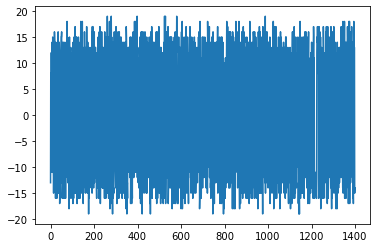

In [33]:
plt.plot(episode_reward_history)

(array([ 9., 11., 22., 22., 62., 27., 24., 17., 13.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  7., 24., 24., 55.,
        20., 23., 12., 24.]),
 array([-19.        , -17.76666667, -16.53333333, -15.3       ,
        -14.06666667, -12.83333333, -11.6       , -10.36666667,
         -9.13333333,  -7.9       ,  -6.66666667,  -5.43333333,
         -4.2       ,  -2.96666667,  -1.73333333,  -0.5       ,
          0.73333333,   1.96666667,   3.2       ,   4.43333333,
          5.66666667,   6.9       ,   8.13333333,   9.36666667,
         10.6       ,  11.83333333,  13.06666667,  14.3       ,
         15.53333333,  16.76666667,  18.        ]),
 <BarContainer object of 30 artists>)

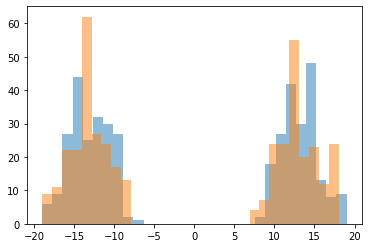

In [34]:
plt.hist(episode_reward_history[:400], bins=30, alpha=0.5, label='init')
plt.hist(episode_reward_history[-400:], bins=30, alpha=0.5, label='last')

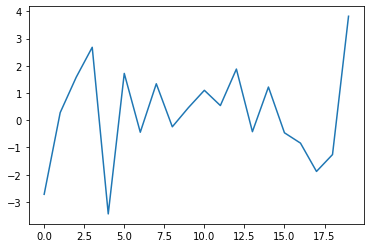

In [35]:
plt.plot(monitor_reward_history)